## Exercise 1: Bayesian optimization

1. Define an objective function which returns the analytic expression of a 1d
   polynomial with coefficients `f(x) = 0.05 (x^6 - 2 x^5 - 28 x^4 + 28 x^3 + 12 x^2 -26 x + 100)`.

2. Plot the previous function using a linear grid of points in x between [-5, 6].

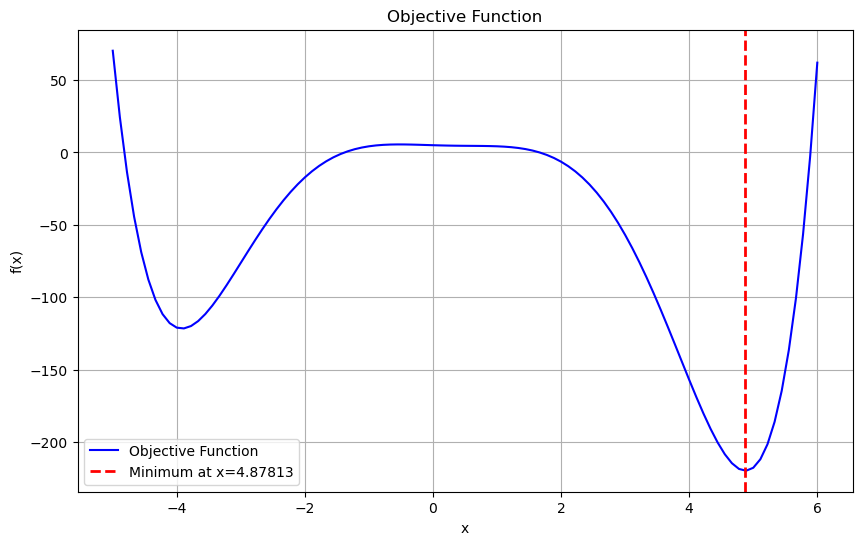

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from hyperopt import hp, pyll

def objective_function(x):
    """
    Objective function to be minimized.
    """
    return 0.05*( x**6 - 2*x**5 - 28*x**4 + 28*x**3 + 12*x**2 -26*x + 100)

x = np.linspace(-5, 6, 100)
y = objective_function(x)
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Objective Function', color='blue')
plt.axvline(4.87813, color='red', ls='--', lw=2, label='Minimum at x=4.87813')
plt.title('Objective Function')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid()
plt.legend()
plt.show()


$$\min{0.05 (x^6 - 2 x^5 - 28 x^4 + 28 x^3 + 12 x^2 - 26 x + 100)}≈-219.801 \quad \text{at} \quad x≈4.87813$$

3. Define an uniform search domain space using hyperopt. With
   `hyperopt.pyll.stochastic.sample` build an histogram with samples from that
   space.

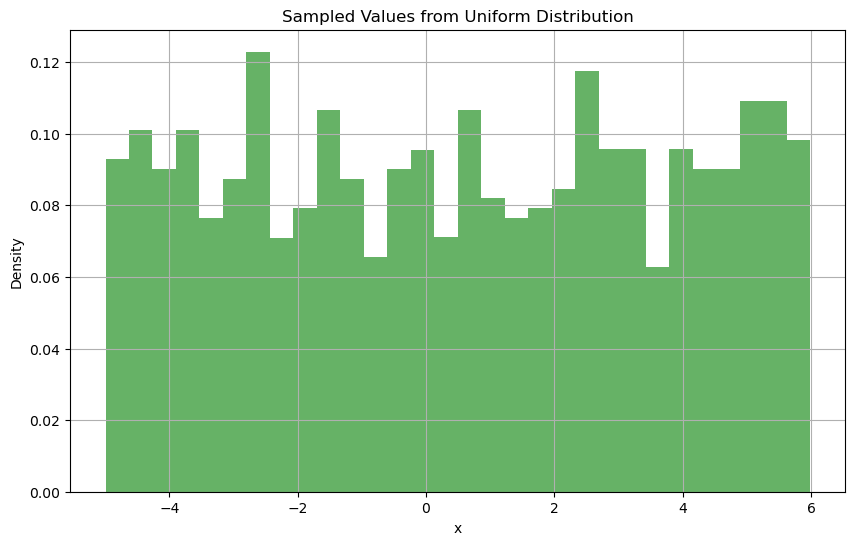

In [2]:
a = hp.uniform("a", 5, 6)


# Define the search space
space = {'x': hp.uniform('x', -5, 6)} # dictionary with one key-value pair

# Generate samples
samples = [pyll.stochastic.sample(space)['x'] for _ in range(1000)] # pyll.stochastic.sample returns a dictionary, so we access the 'x' key

plt.figure(figsize=(10, 6))
plt.hist(samples, bins=30, density=True, alpha=0.6, color='g')
plt.title('Sampled Values from Uniform Distribution')
plt.xlabel('x')
plt.ylabel('Density')
plt.grid()
plt.show()

4. Perform the objective function minimization using the Tree-structured Parzen
   Estimator model, 2000 evaluations and store the trials using
   `hyperopt.Trials`. Print to screen the best value of x. Show scatter plot
   with the x-value vs iteration together with the final best value of x. Show
   the histogram of x-values extracted during the scan.


100%|██████████| 2000/2000 [00:08<00:00, 242.38trial/s, best loss: -219.80119227832392]
Best x found with TPE: 4.877831392930189


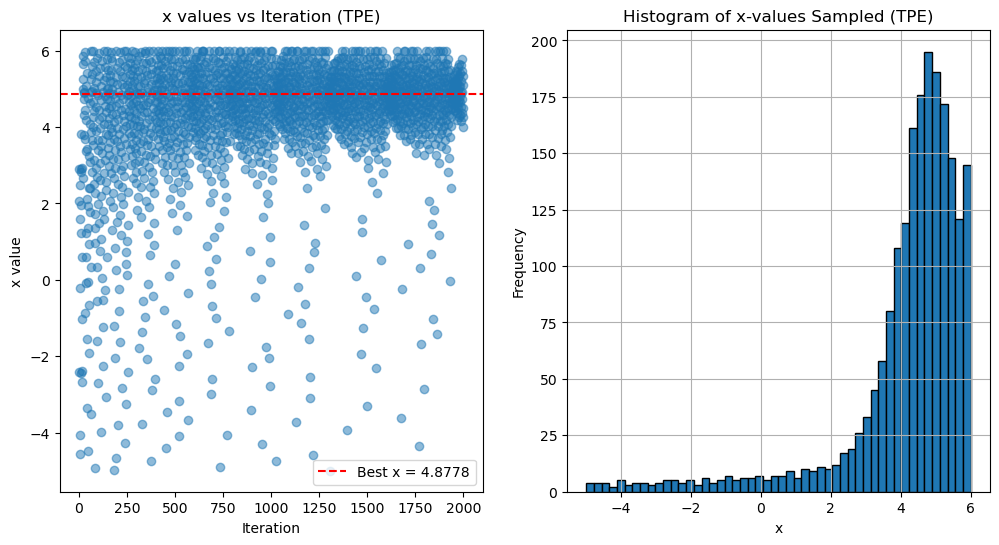

In [3]:
from hyperopt import fmin, tpe, Trials, STATUS_OK

# Define the objective function for Hyperopt
def hyperopt_objective(params):
    x = params['x']
    return {'loss': objective_function(x), 'status': STATUS_OK}  # return a dictionary with loss and status, minimizing the objective function

# Initialize Trials object
trials = Trials() # Trials object to store information about the optimization process, it's a list of dictionaries

# Run optimization
# fmin (fn = objective function, space = search space, algo = algorithm, max_evals = number of evaluations, trials = Trials object to store results)
best = fmin(
    fn=hyperopt_objective,
    space=space,
    algo=tpe.suggest, # tpe.suggest is the Tree-structured Parzen Estimator algorithm, suggests the next point to evaluate based on previous evaluations
    max_evals=2000,
    trials=trials
)

print(f"Best x found with TPE: {best['x']}")

# Extract x values from trials
x_values_tpe = [trial['misc']['vals']['x'][0] for trial in trials.trials]

# Scatter plot of x values vs iteration
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)

plt.scatter(range(len(x_values_tpe)), x_values_tpe, alpha=0.5)
plt.axhline(y=best['x'], color='r', linestyle='--', label=f'Best x = {best["x"]:.4f}')
plt.xlabel('Iteration')
plt.ylabel('x value')
plt.title('x values vs Iteration (TPE)')
plt.legend()

plt.subplot(1, 2, 2)
# Histogram of x values
plt.hist(x_values_tpe, bins=50, edgecolor='k')
plt.title('Histogram of x-values Sampled (TPE)')
plt.xlabel('x')
plt.ylabel('Frequency')
plt.grid()
plt.show()

 TPE is a Bayesian optimization method that efficiently explores the parameter space. The trials object captures all evaluations, allowing analysis of the optimization process

5. Repeat the previous point now using a random search algorithm.

100%|██████████| 2000/2000 [00:02<00:00, 765.46trial/s, best loss: -219.79362387866578] 
Best x found with Random Search: 4.8704754888143125


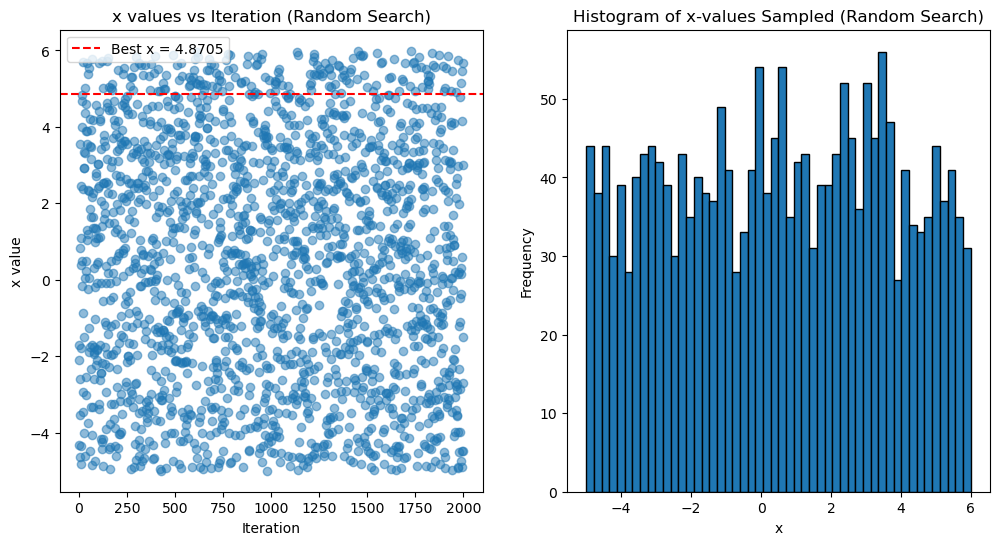

In [4]:
from hyperopt import rand

# Initialize Trials object for random search
random_trials = Trials()

# Run optimization with random search
best_random = fmin(
    fn=hyperopt_objective,
    space=space,
    algo=rand.suggest,
    max_evals=2000,
    trials=random_trials
)

print(f"Best x found with Random Search: {best_random['x']}")

# Extract x values from random trials
x_values_rand = [trial['misc']['vals']['x'][0] for trial in random_trials.trials]

# Scatter plot of x values vs iteration
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(range(len(x_values_rand)), x_values_rand, alpha=0.5)
plt.axhline(y=best_random['x'], color='r', linestyle='--', label=f'Best x = {best_random["x"]:.4f}')
plt.xlabel('Iteration')
plt.ylabel('x value')
plt.title('x values vs Iteration (Random Search)')
plt.legend()

plt.subplot(1, 2, 2)
# Histogram of x values
plt.hist(x_values_rand, bins=50, edgecolor='k')
plt.title('Histogram of x-values Sampled (Random Search)')
plt.xlabel('x')
plt.ylabel('Frequency')
plt.show()

 random search samples uniformly across the domain, providing a comparison to TPE's directed search.

## Exercise 2: Hyperparameter scan for classifier

Write a DL regression model using Keras with the following steps:

**Data loading**

1. Load the mnist dataset from `tensorflow.keras.datasets.mnist`. Study the dataset size (shape) and normalize the pixels.

In [9]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from hyperopt import space_eval

X_train shape: (54000, 784) and y_train shape: (54000,)
X_test shape: (10000, 784) and y_test shape: (10000,)


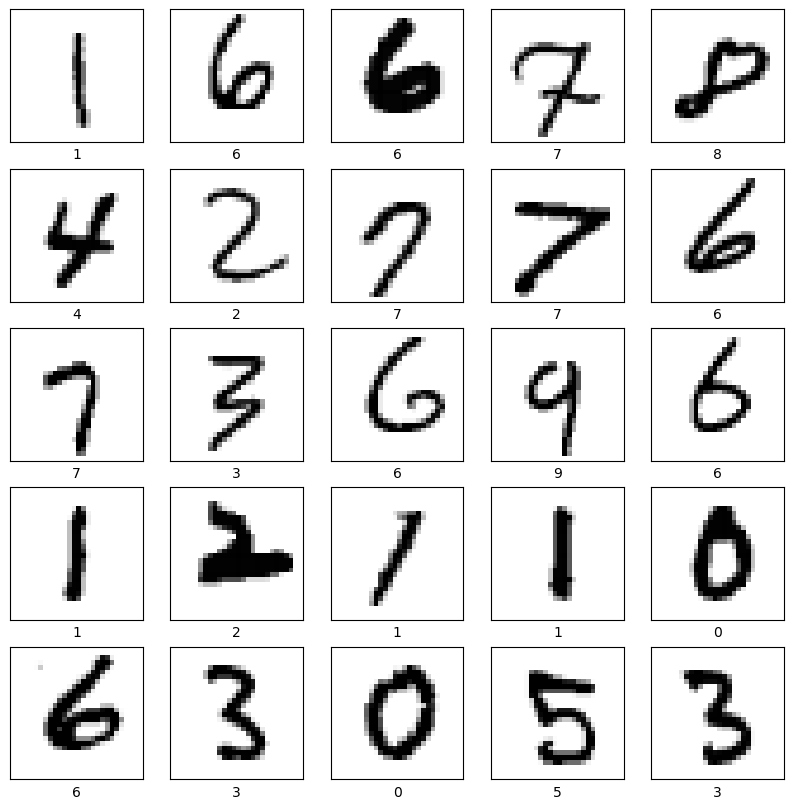

In [19]:
# 1. Load and preprocess data
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

# Normalize and flatten images
X_train_full = X_train_full.reshape(-1, 784).astype('float32') / 255.0
X_test = X_test.reshape(-1, 784).astype('float32') / 255.0

# Split training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=42
)

print(f"X_train shape: {X_train.shape} and y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape} and y_test shape: {y_test.shape}")
# Normalize the data    
X_train, X_test = X_train / 255.0, X_test / 255.0
# Normalize and flatten images
X_train_full = X_train_full.reshape(-1, 784).astype('float32') / 255.0
X_test = X_test.reshape(-1, 784).astype('float32') / 255.0

def plot_sample(images, labels):
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(labels[i])
    plt.show()

plot_sample(X_train.reshape(-1,28,28), y_train)

**DNN model**

2. Design a NN architecture for the classification of all digits.

2025-04-06 21:23:45.586470: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-04-06 21:23:45.663717: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 169344000 exceeds 10% of free system memory.


Epoch 1/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5892 - loss: 1.2690 - val_accuracy: 0.8008 - val_loss: 49.3611
Epoch 2/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8768 - loss: 0.4154 - val_accuracy: 0.8210 - val_loss: 50.3450
Epoch 3/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9008 - loss: 0.3365 - val_accuracy: 0.8353 - val_loss: 46.9607
Epoch 4/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9131 - loss: 0.2966 - val_accuracy: 0.8635 - val_loss: 39.7364
Epoch 5/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9247 - loss: 0.2603 - val_accuracy: 0.8918 - val_loss: 32.3342
Epoch 6/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9312 - loss: 0.2292 - val_accuracy: 0.9110 - val_loss: 27.0093
Epoch 7/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9408 - loss: 0.2046 - val_accuracy: 0.9210 - val_loss: 23.6267
Epoch 8/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9464 - loss: 0.

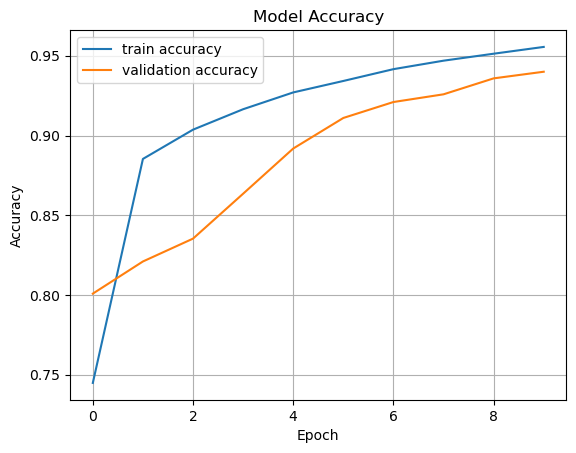

In [ ]:
# 2. Define model-building function
def create_model(params):
    model = Sequential()
    model.add(Input(shape=(784,)))
    for _ in range(params['n_layers']):
        model.add(Dense(params['n_units'], activation='relu'))
    model.add(Dense(10, activation='softmax'))
    optimizer = Adam(learning_rate=params['learning_rate'])
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

params = {
    'n_layers': 2,
    'n_units': 128,
    'learning_rate': 0.001
}
model = create_model(params)
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))
print(f"Training accuracy: {history.history['accuracy'][-1]}")
print(f"Validation accuracy: {history.history['val_accuracy'][-1]}")

plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.legend()
plt.show()

**Hyperparameter scan**

3. Define a function which parametrizes the learning rate and the number of
   units of the DNN model using a python dict.

In [22]:
# 3. Hyperparameter tuning setup
space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-2)), # learning rate between 0.0001 and 0.01
    'n_units': hp.quniform('n_units', 32, 512, 32), # number of units in each layer, between 32 and 512 with step size of 32 (16 options)
    'n_layers': hp.choice('n_layers', [1, 2, 3]), # number of layers (1, 2, or 3)
}

def objective(params):
    params = params.copy()
    params['n_units'] = int(params['n_units'])  # Ensure integer units
    
    model = create_model(params)
    
    # Train model with early stopping to prevent overfitting
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=10,
        batch_size=64,
        verbose=0
    )
    
    # Track validation accuracy
    val_accuracy = max(history.history['val_accuracy'])
    return {
        'loss': 1 - val_accuracy,
        'status': STATUS_OK,
        'params': params,
        'accuracy': val_accuracy
    }

4. Use the Tree-structured Parzen Estimator with the
   [hyperopt](http://hyperopt.github.io/hyperopt/) library.

In [23]:
# Run hyperparameter optimization
trials = Trials()
best = fmin(
    fn = objective,
    space=space,
    algo=tpe.suggest,
    max_evals = 20,
    trials=trials
)

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

2025-04-06 21:25:54.702045: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 169344000 exceeds 10% of free system memory.


  5%|▌         | 1/20 [00:16<05:13, 16.49s/trial, best loss: 0.2095000147819519]

2025-04-06 21:26:11.197040: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 169344000 exceeds 10% of free system memory.


 10%|█         | 2/20 [00:38<05:54, 19.68s/trial, best loss: 0.08300000429153442]

2025-04-06 21:26:33.104958: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 169344000 exceeds 10% of free system memory.


 15%|█▌        | 3/20 [00:56<05:19, 18.79s/trial, best loss: 0.08300000429153442]

2025-04-06 21:26:50.836857: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 169344000 exceeds 10% of free system memory.


100%|██████████| 20/20 [06:37<00:00, 19.89s/trial, best loss: 0.04533332586288452] 


5. Plot the accuracy vs learning rate and number of layers for each trial.

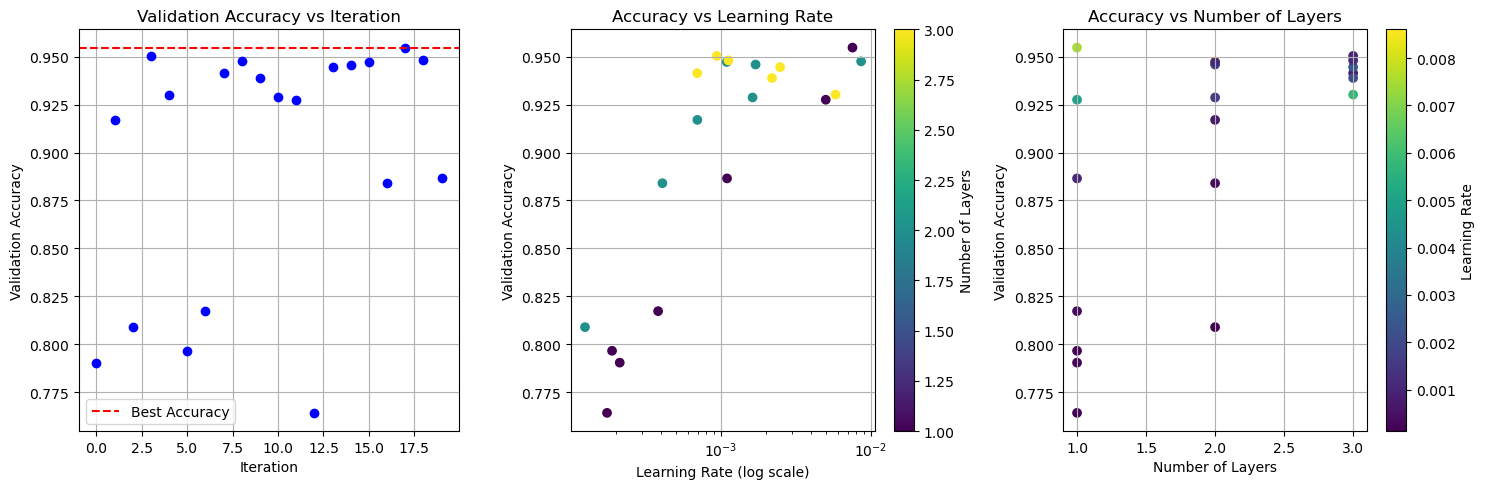

In [31]:
import matplotlib.pyplot as plt

# Extract results from trials
results = [trial['result'] for trial in trials]

# Extract parameters and accuracy from the results
learning_rates = [res['params']['learning_rate'] for res in results]
accuracies = [res['accuracy'] for res in results]
n_layers = [res['params']['n_layers'] for res in results]

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Accuracy vs iteration
ax1.plot(range(len(accuracies)), accuracies, marker='o', linestyle=' ', color='b')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Validation Accuracy')
ax1.set_title('Validation Accuracy vs Iteration')
ax1.axhline(y=max(accuracies), color='r', linestyle='--', label='Best Accuracy')
ax1.legend()
ax1.grid()

# Plot 2: Accuracy vs Learning Rate
sc2 = ax2.scatter(learning_rates, accuracies, c=n_layers, cmap='viridis')
ax2.set_xscale('log')  # Log scale for learning rate
ax2.set_xlabel('Learning Rate (log scale)')
ax2.set_ylabel('Validation Accuracy')
ax2.set_title('Accuracy vs Learning Rate')
ax2.grid()
plt.colorbar(sc2, ax=ax2, label='Number of Layers')
# Plot 3: Accuracy vs Number of Layers
sc3 = ax3.scatter(n_layers, accuracies, c=learning_rates, cmap='viridis')
ax3.set_xlabel('Number of Layers')
ax3.set_ylabel('Validation Accuracy')
ax3.set_title('Accuracy vs Number of Layers')
ax3.grid()
plt.colorbar(sc3, ax=ax3, label='Learning Rate')

plt.tight_layout()
plt.show()
